# Scattershot Boson Sampling

Implementation of [this paper](https://arxiv.org/pdf/1305.4346.pdf) in Strawberry Fields.

As we have seen in the Boson Sampling (BS) tutorial, a boson sampler is a quantum machine that takes a deterministic input made of $m$ modes, $n$ of them sending photons simultaneously through an interferometer modeled by a unitary matrix $U$. The output of the interferometer is a random distribution of photons that can be computed classically with the permanent of $U$. 

Scattershot Boson Sampling (SBS) was motivated by the fact that emitting $n$ photons simultaneously in the input is experimentally very hard to realize for large $n$. What is simpler to build is a random input using Spontaneous Parametric Down-Conversion (SPDC), whose distribution is given by $P(k_i = k)=(1-\chi^2) \chi^{2 k}$ where $k_i$ is the number of photon in mode i and $\chi \in (-1,1)$ is a given parameter (equation (7) of the paper). The advantage of SPDC is not only that it's a coherent source of photons but also that it always emits an even number of photons: one that can be used in a boson sampling circuit and one to measure the input.

In quantum optics, we model SPDC by 2-mode squeezing gates $\hat{S}_2$ such that $\hat{S}_2 |0 \rangle |0 \rangle = \sqrt{(1-\chi^2)} \sum_{k=0}^{\infty} \chi^k |k \rangle |k \rangle$ (equation (3) of the paper). The first qubit will be used to measure the input while the second will be sent to the circuit. 

In SF, this 2-mode squeezing gate is called S2gate and takes as input a squeezing parameter $r$ related to $\chi$ by the formula $r=\tanh(\chi)$

In [ ]:
import numpy as np
import scipy as sp
from math import factorial, tanh
import itertools

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.path as mpath
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection

import strawberryfields as sf
from strawberryfields.ops import *

In [2]:
colormap = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])

## Constructing the circuit

### Constants

Our circuit will depend on a few parameters. The first constants are the squeezing parameter $r \in [-1,1]$ (already described in introduction) and the cutoff number, which corresponds to the maximum number of photons per mode considered in the computation (used to make the simulation tractable).

In [3]:
r_squeezing = 0.4 # squeezing parameter for the S2gate (here taken randomly between -1 and 1)
cutoff = 7 # max number of photons computed per mode

Then comes the unitary matrix, representing the interferometer. We have decided to implement a 4-modes boson sampler, and we therefore need a $4 \times 4$-unitary matrix. Any kind of such unitary matrix could do well, but for simplicity, we choose to implement it using two rotations: one with angle $\theta_1$ for the qubits 1 and 2, and another with angle $\theta_2$ for the qubits 3 and 4. The final matrix has the form: $\begin{pmatrix} \cos(\theta_1) & - \sin(\theta_1) & 0 & 0  \\ \sin(\theta_1) & cos(\theta_1) & 0 & 0 \\ 0 & 0 & \cos(\theta_2) & - \sin(\theta_2) \\ 0 & 0 & \cos(\theta_2) & \sin(\theta_2) \end{pmatrix}$ with $\theta_1, \theta_2 \in [0,2\pi)$.

In [4]:
theta1 = 0.5
theta2 = 1

U = np.array([[np.cos(theta1), -np.sin(theta1), 0,               0             ],
              [np.sin(theta1),  np.cos(theta1), 0,               0             ],
              [0,               0,              np.cos(theta2), -np.sin(theta2)],
              [0,               0,              np.sin(theta2),  np.cos(theta2)]])

### Circuit

We instantiate our circuit with 8 qubits, 4 for the input, 4 for the output.

In [5]:
eng, q = sf.Engine(8)

We can then declare our circuit. The first four lines are 2-modes squeezing gates, which generate a random number of photons  

In [6]:
with eng:
    S2gate(r_squeezing) | (q[0], q[4])
    S2gate(r_squeezing) | (q[1], q[5])
    S2gate(r_squeezing) | (q[2], q[6])
    S2gate(r_squeezing) | (q[3], q[7])

    Interferometer(U) | (q[4], q[5], q[6], q[7])

### Running

Run the simulation up to 'cutoff' photons per mode

In [7]:
state = eng.run('fock', cutoff_dim=cutoff)

Get the probability associated to each state

In [8]:
probs = state.all_fock_probs()

Reshape 'probs' such that probs[k_1, k_2,...] gives the proba of the state $(k_1, k_2,...)$ (with $k_i$ the number of photons in mode $i$)

In [9]:
probs = probs.reshape(*[cutoff]*8)

The sum is not 1 because of the finite cutoff:

In [10]:
np.sum(probs)

0.9989275585486406

## Analysis

The goal of this section is to compare the simulated probability with the theoretical one. 

### Computation of the theoretical probability

To do so, the first step is to compute the theoretical probability $P(\textrm{input}=(m_1, m_2, m_3, m_4), \textrm{output}=(n_1, n_2, n_3, n_4))$, where $m_i,n_i \in \mathbb{N}$ represent the number of photons respectively in input and output modes $i$.   Using the definition of conditional probability, we can decompose it as:

\\[
P(\textrm{input}, \textrm{output}) = P(\textrm{output} \mid \textrm{input}) P(\textrm{input}) 
\\]

The value of $P(\textrm{output} \mid \textrm{input})$ is given in the [Boson Sampling tutorial](https://strawberryfields.readthedocs.io/en/latest/tutorials/tutorial_boson_sampling.html#boson-tutorial):

\\[
P(\textrm{input}=(m_1, m_2, m_3, m_4) \mid \textrm{output}=(n_1, n_2, n_3, n_4)) = \frac{\left| \textrm{Perm}(U_{st}) \right| ^2}{n_1! n_2! n_3! n_4! m_1! m_2! m_3! m_4!}
\\]

while $P(\textrm{input})$ depends on the SPDC properties (see introduction) and can be computed in the following way:


\\[
\begin{equation}
\begin{split}
P(\textrm{input} =(m_1, m_2, m_3, m_4)) &= \prod_{i=1}^4 P(m_i) \\
 & = \prod_{i=1}^4 (1-\chi^2) \chi^{2m_i} \\
 & = (1-\chi^2)^4 \chi^{2 \sum m_i} \\
 & = (1-\chi^2)^n \chi^{2 m}
\end{split}
\end{equation}
\\]

with $n$ the number of modes (here 4) and $m=\sum m_i$ the total number of photons. The value of $P(m_i)$ is directly taken from the original paper (equation (7)).

Using that, we can now perform the computation.

First, the permanent of the matrix (code from the [BS tutorial](https://strawberryfields.readthedocs.io/en/latest/tutorials/tutorial_boson_sampling.html#boson-tutorial)): 

In [11]:
def perm(M):
    n_output = M.shape[0]
    n_input = M.shape[1]
    if n_output != n_input: # if non-conservation of photon number
        return 0
    n = n_input
    if n == 0:
        return 1
    d = np.ones(n)
    j =  0
    s = 1
    f = np.arange(n)
    v = M.sum(axis=0)
    p = np.prod(v)
    while (j < n-1):
        v -= 2*d[j]*M[j]
        d[j] = -d[j]
        s = -s
        prod = np.prod(v)
        p += s*prod
        f[0] = 0
        f[j] = f[j+1]
        f[j+1] = j+1
        j = f[0]    
    
    return p/2**(n-1)

Then the probability of the output given an input. For that, we use the algorithm given in section V of [this paper](https://arxiv.org/pdf/1212.2240.pdf) to compute the matrix $U_{st}$ (called $U_{I,O}$ in the cited paper). To sum it up, it consists in extracting $m_j$ times the column $j$ of $U$ for every $j$, and $n_i$ times the row $i$ of $U$ for every $i$ (with $m_j$ and $n_i$ still representing the number of photons respectively in input $j$ and output $i$).

In [12]:
def get_proba_output(U, input, output):
    # The two lines below are the extracted row and column indices.
    # For instance, for output=[3,2,1,0], we want list_rows=[0,0,0,1,1,2].
    # sum(.,[]) is a Python trick to flatten the list
    list_rows = sum([[i] * output[i] for i in range(len(output))],[])
    list_columns = sum([[i] * input[i] for i in range(len(input))],[])
    
    U_st = U[:,list_columns][list_rows,:]
    perm_squared = np.abs(perm(U_st))**2
    denominator = np.prod([factorial(inp) for inp in input]) * np.prod([factorial(out) for out in output])
    return perm_squared / denominator

In [13]:
def get_proba_input(input):
    chi = np.tanh(r_squeezing)
    n = np.sum(input)
    m = len(input)
    return (1 - chi**2)**m * chi**(2*n)

In [14]:
def get_proba(U, result):
    input, output = result[0:4], result[4:8]
    return get_proba_output(U, input, output) * get_proba_input(input) # P(O,I) = P(O|I) P(I)

### Comparison between theory and simulation

In [15]:
print("Theory: \t", get_proba(U, [0,0,0,0,0,0,0,0]))
print("Simulation: \t", probs[0,0,0,0,0,0,0,0])

Theory: 	 0.535996373869716
Simulation: 	 0.5359963738697161


In [16]:
print("Theory: \t", get_proba(U, [1,0,0,0,1,0,0,0]))
print("Simulation: \t", probs[1,0,0,0,1,0,0,0])

Theory: 	 0.05959205290845597
Simulation: 	 0.059592052908455956


In [17]:
print("Theory: \t", get_proba(U, [1,0,0,0,0,1,0,0]))
print("Simulation: \t", probs[1,0,0,0,0,1,0,0])

Theory: 	 0.01778503427946317
Simulation: 	 0.017785034279463166


We see that the results are very similar

## Visualization

To visualize the results and the effect of a scattershot boson sampler, we will draw some examples of sampling.

### Make the probabilities sum to 1
Due to computational issues, the sum of the probability does not equal 1. Since it prevents us from sampling correctly, we choose to add the missing weight to the outcome [0,0,0,0, 0,0,0,0]

In [18]:
probs[0,0,0,0, 0,0,0,0] += 1 - np.sum(probs)

In [19]:
np.sum(probs)

1.0

### Sample

Get all possible choices as a list of outcomes [$k_1$,...,$k_8$] with $k_i \in \{1,...,cutoff\}$

In [20]:
list_choices = list(itertools.product(*[range(cutoff)]*8))
list_choices[0]

(0, 0, 0, 0, 0, 0, 0, 0)

Get the probability of each choice index

In [21]:
list_probs = [probs[list_choices[i]] for i in range(len(list_choices))]

Sample a choice using this probability distribution

In [22]:
choice = list_choices[np.random.choice(range(len(list_choices)), p=list_probs)]

### Visualize

(-0.05, 1.05, -0.025, 0.525)

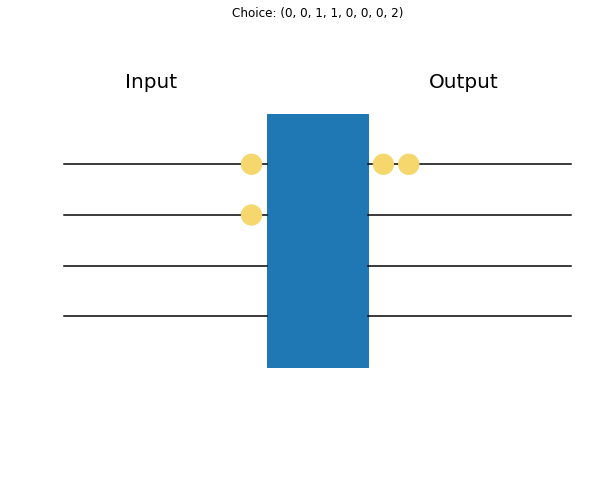

In [23]:
# Constants

color_rect = colormap[0]
color_lines = "black"
color_photons = "#F5D76E"
radius_photons = 0.02
margin_photons = 0.01
x_begin_rect, x_end_rect = 0.4, 0.6

# Sample

choice = list_choices[np.random.choice(range(len(list_choices)), p=list_probs)]

# Plot

fig, ax = plt.subplots()
fig.set_size_inches(10, 8)

rect = mpatches.Rectangle((x_begin_rect,0),x_end_rect-x_begin_rect, 0.5,edgecolor=color_rect,facecolor=color_rect)
ax.add_patch(rect)

for i_line, y_line in enumerate(np.linspace(0.1,0.4,4), 0):
    # draw the lines
    plt.plot([0,x_begin_rect], [y_line,y_line], color=color_lines)
    plt.plot([x_end_rect, 1], [y_line,y_line], color=color_lines)

    # draw the input photons
    for i_photon in range(choice[i_line]):
        x_photon = x_begin_rect - margin_photons - radius_photons - i_photon*(radius_photons*2 + margin_photons)
        circle = mpatches.Circle([x_photon,y_line], radius_photons, color=color_photons, zorder=3)
        ax.add_patch(circle)
    
    # draw the output photons
    for i_photon in range(choice[4 + i_line]):
        x_photon = x_end_rect + margin_photons + radius_photons + i_photon*(radius_photons*2 + margin_photons)
        circle = mpatches.Circle([x_photon,y_line], radius_photons, color=color_photons, zorder=3)
        ax.add_patch(circle)
        

ax.text(0.12, 0.55, 'Input', size=20)
ax.text(0.72, 0.55, 'Output', size=20)
        
plt.title("Choice: {}".format(choice))
plt.axis('equal')
plt.axis('off')

In this figure, each line represent a mode (input on the left and output on the right), the blue rectangle is the interferometer, and each yellow point is a photon. The overall drawing represents a example of sampling (each time you execute the cell, it samples a new state)